# Exploratory Data Analysis Rossmann Store Sales

## Data Description

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

Files

- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores

Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince\[Month/Year\] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since\[Year/Week\] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## Performance Measure

Root Mean Square Percentage Error (RMSPE):

$RMSEP = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i - \hat{y}}{y_i})^2}$

## loading the datasets

In [1]:
import pandas as pd

In [2]:
def load_csv_data(path, delimiter):
    return pd.read_csv(path, delimiter=delimiter)

In [3]:
df_train = load_csv_data('/home/timbo/repos/kaggle/rossmann/datasets/train.csv', ',')

/home/timbo/miniconda3/envs/rossmann/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
df_test = load_csv_data('/home/timbo/repos/kaggle/rossmann/datasets/test.csv', ',')

In [5]:
df_stores = load_csv_data('/home/timbo/repos/kaggle/rossmann/datasets/store.csv', ',')

## Quick Look at the Data Structure

In [6]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
df_train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

<p style="color:red;"> 'StateHoliday' in the train dataset contains integers and strings. This is the reason for the pandas warning from above and column 7 has dytpe 'object'</p>

In [9]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


<p style="color:red;"> 'Sales' is the target in the training set</p>

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [11]:
df_test['Open'].isnull().sum()

11

<p style="color:red;">'Open' contains 11 null values</p>

In [12]:
df_test[df_test['Open'].isnull() == True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [13]:
df_stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


<p style="color:red;"> 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear' and 'PromoInterval' contain null values</p>

In [15]:
def show_null_rows(df, col_name):
    return df[df[col_name].isnull() == True]

In [16]:
show_null_rows(df_stores,'CompetitionOpenSinceMonth')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [17]:
show_null_rows(df_stores,'CompetitionOpenSinceYear')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [18]:
show_null_rows(df_stores,'CompetitionOpenSinceMonth').equals(show_null_rows(df_stores,'CompetitionOpenSinceYear'))

True

<p style="color:red;">null values between 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' are the same</p>

In [19]:
show_null_rows(df_stores,'Promo2SinceWeek')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [20]:
show_null_rows(df_stores,'Promo2SinceYear')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [21]:
show_null_rows(df_stores,'PromoInterval')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [22]:
show_null_rows(df_stores,'Promo2SinceWeek').equals(show_null_rows(df_stores,'Promo2SinceYear'))

True

In [23]:
show_null_rows(df_stores,'PromoInterval').equals(show_null_rows(df_stores,'Promo2SinceYear'))

True

<p style="color:red;">null values between 'Promo2SinceWeek', 'Promo2SinceYear' and 'PromoInterval' are the same</p>

## attributes encoding

In [24]:
def display_value_counts(df):
    for col in df.columns:
        display(df[col].value_counts())

In [25]:
display_value_counts(df_train)

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

2014-02-27    1115
2015-03-26    1115
2013-07-10    1115
2013-03-22    1115
2015-06-14    1115
              ... 
2014-10-13     935
2014-08-21     935
2014-07-08     935
2014-09-19     935
2014-09-11     935
Name: Date, Length: 942, dtype: int64

0        172871
5674        215
5558        197
5483        196
6049        195
          ...  
32605         1
24275         1
26167         1
17971         1
22905         1
Name: Sales, Length: 21734, dtype: int64

0       172869
560       2414
576       2363
603       2337
571       2330
         ...  
4328         1
4894         1
4160         1
3972         1
3485         1
Name: Customers, Length: 4086, dtype: int64

1    844392
0    172817
Name: Open, dtype: int64

0    629129
1    388080
Name: Promo, dtype: int64

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [26]:
display_value_counts(df_test)

2047     1
36091    1
40281    1
38232    1
11599    1
        ..
39590    1
33445    1
35492    1
21151    1
2049     1
Name: Id, Length: 41088, dtype: int64

1087    48
107     48
43      48
11      48
1066    48
        ..
245     48
213     48
181     48
149     48
32      48
Name: Store, Length: 856, dtype: int64

7    5992
6    5992
4    5992
3    5992
2    5992
1    5992
5    5136
Name: DayOfWeek, dtype: int64

2015-08-15    856
2015-08-19    856
2015-09-04    856
2015-08-18    856
2015-08-26    856
2015-08-09    856
2015-08-31    856
2015-08-16    856
2015-08-14    856
2015-09-11    856
2015-08-12    856
2015-08-29    856
2015-08-28    856
2015-09-17    856
2015-09-10    856
2015-08-06    856
2015-08-25    856
2015-08-10    856
2015-08-20    856
2015-09-02    856
2015-08-01    856
2015-08-11    856
2015-08-27    856
2015-09-06    856
2015-09-12    856
2015-08-30    856
2015-08-08    856
2015-08-23    856
2015-08-03    856
2015-08-22    856
2015-08-07    856
2015-08-13    856
2015-08-21    856
2015-09-14    856
2015-09-13    856
2015-09-05    856
2015-09-16    856
2015-08-02    856
2015-09-09    856
2015-08-04    856
2015-09-01    856
2015-09-08    856
2015-09-07    856
2015-08-17    856
2015-08-05    856
2015-09-03    856
2015-09-15    856
2015-08-24    856
Name: Date, dtype: int64

1.0    35093
0.0     5984
Name: Open, dtype: int64

0    24824
1    16264
Name: Promo, dtype: int64

0    40908
a      180
Name: StateHoliday, dtype: int64

0    22866
1    18222
Name: SchoolHoliday, dtype: int64

<p style="color:red;">The following columns in the training and test datasets are nominal categorical: 'Store',  'Open', 'Promo', 'StateHoliday' and 'SchoolHoliday'. The following columns are ordinal categorical: 'DayOfWeek', 'Date'. No column except the target column is numerical.</p>

The 'id' column is only in the test set

In [27]:
display_value_counts(df_stores)

1115    1
374     1
368     1
369     1
370     1
       ..
738     1
737     1
736     1
735     1
1       1
Name: Store, Length: 1115, dtype: int64

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

a    593
c    513
b      9
Name: Assortment, dtype: int64

250.0      12
1200.0      9
350.0       8
50.0        8
190.0       8
           ..
18650.0     1
8540.0      1
15700.0     1
6900.0      1
5710.0      1
Name: CompetitionDistance, Length: 654, dtype: int64

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2011.0    54
2009.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1900.0     1
1961.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

1    571
0    544
Name: Promo2, dtype: int64

14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
37.0    35
1.0     35
45.0    34
13.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    11
36.0    10
48.0     9
39.0     6
23.0     5
44.0     3
49.0     1
6.0      1
26.0     1
50.0     1
28.0     1
Name: Promo2SinceWeek, dtype: int64

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

<p style="color:red;">The following columns in the stores dataset are nominal categorical: 'Store', 'StoreType', 'Assortment', 'Promo2' and 'PromoInterval'. 
The following columns are ordinal categorical: 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek' and 'CompetitionOpenSinceYear'.
The following columns are numerical: 'CompetitionDistance' </p>

In [28]:
df_stores[['CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2SinceYear', 'Promo2SinceWeek']].describe()

,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceYear,Promo2SinceWeek
count,1112.000000,761.000000,761.000000,571.000000,571.000000
mean,5404.901079,7.224704,2008.668857,2011.763573,23.595447
std,7663.174720,3.212348,6.195983,1.674935,14.141984
min,20.000000,1.000000,1900.000000,2009.000000,1.000000
25%,717.500000,4.000000,2006.000000,2011.000000,13.000000
50%,2325.000000,8.000000,2010.000000,2012.000000,22.000000
75%,6882.500000,10.000000,2013.000000,2013.000000,37.000000
max,75860.000000,12.000000,2015.000000,2015.000000,50.000000


## How should the submission look like?

In [29]:
load_csv_data('/home/timbo/repos/kaggle/rossmann/datasets/sample_submission.csv', ',')

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


This is the same order as in the test set

## How are the datasets splitted?

are all stores from df_store also in both datasets?

This is important for the cross-validation strategy

## Visualization

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

The following columns in the training and test datasets are nominal categorical: 'Store', 'Open', 'Promo', 'StateHoliday' and 'SchoolHoliday'. The following columns are ordinal categorical: 'DayOfWeek', 'Date'. No column except the target column is numerical.

The following columns in the stores dataset are nominal categorical: 'Store', 'StoreType', 'Assortment', 'Promo2' and 'PromoInterval'. The following columns are ordinal categorical: 'CompetitionOpenSinceMonth', 'Promo2SinceYear', 'Promo2SinceWeek' and 'CompetitionOpenSinceYear'. The following columns are numerical: 'CompetitionDistance'.

### univariate analysis: nominal categorical data

check if the same stores are in both datasets and check if this attribute an be excluded as feature

In [8]:
df_train['Store'].value_counts().plot.bar()

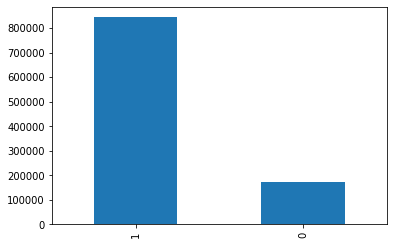

In [7]:
df_train['Open'].value_counts().plot.bar()

### univariate analysis: ordinal categorical data

### univariate analysis: numerical data

In [0]:
df_stores['CompetitionDistance'].hist(bins=20)